## Challenges with Large Data

As a Data Scientist, we encounter few major challenges when dealing with large volume of data: 

1. Popular libraries like Numpy, Pandas are not designed to scale beyond a single core/processor. 
2. Numpy, Pandas, Scikit-Learn are not designed to scale beyond a single machine (Scikit-Learn can utilize multiple cores).
3. For a laptop or workstation, RAM is often limited to 16 or 32 GB. For Numpy, Pandas, Scikit-Learn, data needs to be loaded into RAM. So, if size of the data exceeds size of the main memory, these libraries can't be used.

## Why Dask?
Dask is a framework designed to overcome these limitations:

1. Parallelization using multiple cores available in a single Computer or distributed across multiple computers)
2. Out of Core Computing: If size of the data is larger than the main memory (RAM), dask doesn't load all the data in memory at a time. It streams data from the disk as and when needed. If Data doesn't fit into the disk of a single computer, it can be distributed across multiple computers.

Dask can scale on thousand-machine clusters to handle hundreds of terabytes of data. At the same time, it works efficiently on a single machine as well, enabling analysis of moderately large datasets (100GB+) on relatively low power laptops.

In [3]:
import os
import sys

import pandas as pd
import numpy as np

import dask
from dask.distributed import Client
import dask.dataframe as dd

#### How many processors do I have?

In [4]:
os.cpu_count()

10

This is equal to double the number of CPU Cores since in most of the computers hyperthreading is enabled.

**Hyperthreading** tells the operating system that it has two cores for every physical core. In my Window's laptop, I have 6 physical cores (highlighted in **yellow**), but 12 logical processors. But, these 12 logical processors will not give 12x improvement compared to single physical core. Hyperthreading generally gives around 1.25x to 1.3x improvement if two cores give 2x improvement.

<img src="../images/how_many_processors.png" width="400" height="100" style="border-style: solid;">

# Dask Architechture

#### Technically,  Dask is a centrally managed distributed service with distributed storage and execution with the workers and peer to peer communication. 

<img src="../images/dask_architechture_diagram.png" width="600" height="200" style="border-style: solid;">

#### What is a Client?

The Client connects users to a Dask cluster. After a Dask cluster is setup, we initialize a Client by pointing it to the address of a Scheduler:

```python
from distributed import Client
client = Client("1.2.3.4:8786")
```



#### Start Dask Client

In [5]:
os.cpu_count()

10

In [6]:
client = Client(n_workers=10, threads_per_worker=1, memory_limit='2GB')

In [7]:
client

<Client: 'tcp://127.0.0.1:44065' processes=10 threads=10, memory=20.00 GB>

Here we are creating a Client without specifying the scheduler (cluster) address. In this case, the Client creates a `LocalCluster` in the background and connects to that. Any computation will automatically use this `LocalCluster`.

The above code is effectively same as the following:

```python
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=10)
client = Client(cluster)
```

By specifying `n_worker=10`, we have asked to dask to start `10` independent python processes. Based on the nature of the cluster, they may run in the same machine or different machines.

A client can be closed using:

```python
client.close()
```

### Read the Data

#### Description of the Data

Data used in this notebook is from the Kaggle Competition "INGV - Volcanic Eruption Prediction"(https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe).

We will explore a bunch of files under `train` and `test` directories. Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. There are 4432 data files under the train directory and 4521 files under test directory. Each of these files consists of 60K lines. On the disk, size of the files under train and test directory is 30G (15G + 15G).


In [8]:
# Point to the directory where all the CSV files are stored
# DATA_DIR = "../data/train"
DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/train"

#### How many files are there?

In [9]:
! ls {DATA_DIR} | wc -l

4431


#### Take a quick look of the content of an individual file

In [10]:
! head -3 {DATA_DIR}/2019378960.csv

sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
36.0,1050.0,155.0,643.0,-39.0,843.0,-21.0,96.0,-62.0,-1243.0
8.0,856.0,218.0,705.0,10.0,763.0,-117.0,90.0,-165.0,-1348.0


#### What is the size of one of an individual file?

In [11]:
! ls -lh {DATA_DIR}/2019378960.csv

-rw-rw-r-- 1 arnabb arnabb 3.6M Oct  8 23:59 /opt/vssexclude/personal/kaggle/volcano/data/raw/train/2019378960.csv


#### What is the size of all the files together?

In [12]:
! du -h {DATA_DIR}

15G	/opt/vssexclude/personal/kaggle/volcano/data/raw/train


In [13]:
# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

#### Read all the files using **Panda**

- Need to do it sequentially
- Memory occupied by the objects must be less than the Main Memory (RAM)

```python
%%time
for name in os.listdir(DATA_DIR):
    df = pd.read_csv(f"{DATA_DIR}/{name}", dtype=data_types)
```

```
CPU times: user 2min 30s, sys: 1min 5s, total: 3min 35s
Wall time: 3min 42s
```

#### Read all the files using **Dask**

In [14]:
%%time
dd_seg = dd.read_csv(
    urlpath=f"{DATA_DIR}/*.csv", 
    blocksize=None, 
    dtype=data_types)

CPU times: user 550 ms, sys: 79.9 ms, total: 630 ms
Wall time: 632 ms


#### What just happened:
- Dask just checked the input path and found that there are multiple CSV files matching the path description
- It has not really loaded the content of the individual CSV files yet. 
- Nothing happens in the Dask UI, because these operations are just setting up a task graph which will be executed later
- Dask is lazy by default. It will load all the CSV files into the memory **in parallel** only when we ask for any result
- We can ask for result by invoking `compute()` method

Note:
- None value for `blocksize` creates single partition for each CSV file

In [15]:
dd_seg

Dask DataFrame Structure:
                 sensor_1 sensor_2 sensor_3 sensor_4 sensor_5 sensor_6 sensor_7 sensor_8 sensor_9 sensor_10
npartitions=4431                                                                                           
                  float32  float32  float32  float32  float32  float32  float32  float32  float32   float32
                      ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
...                   ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
                      ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
                      ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
Dask Name: read-csv, 4431 tasks

### What is Dask DataFrame?

- Dask DataFrame API extends Pandas to work on **larger than memory** datasets on laptops or distributed datasets across the clusters
- It reuses lot of Pandas' code and extends the scale.

### How Dask DataFrame is constructed?

<img src="../images/pandas_vs_dask_DF.png" width="600" height="200" style="border-style: solid;">

#### Check the shape of the Dask DataFrame

In [16]:
%%time
# Calculate the number of columns
len(dd_seg.columns)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 16.9 µs


10

In [17]:
%%time
# Calculate the number of rows
len(dd_seg)

CPU times: user 23.5 s, sys: 2.76 s, total: 26.3 s
Wall time: 1min 1s


265864431

**There are approximately 265 million rows.**

- Computation of number of columns is fast
- Computation of number of **rows** is slow. 

### To make the exploration process faster, we will select only a subset of files and create a Dask DataFrame out of it.

In [18]:
! ls {DATA_DIR}/1403*.csv | wc -l

6


In [19]:
%%time
dd_sample_small = dd.read_csv(
    urlpath=f"{DATA_DIR}/1403*.csv", 
    blocksize=None, 
    dtype=data_types)

CPU times: user 128 ms, sys: 32.9 ms, total: 160 ms
Wall time: 160 ms


In [20]:
dd_sample_small

Dask DataFrame Structure:
              sensor_1 sensor_2 sensor_3 sensor_4 sensor_5 sensor_6 sensor_7 sensor_8 sensor_9 sensor_10
npartitions=6                                                                                           
               float32  float32  float32  float32  float32  float32  float32  float32  float32   float32
                   ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
...                ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
                   ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
                   ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
Dask Name: read-csv, 6 tasks

#### Observations
- This Dask DataFrame is composed of 6 Pandas DataFrame
- It has the column names and data types
- It has 6 tasks, i.e. 6 small Python functions which must be run to execute this entire Dask DataFrame.

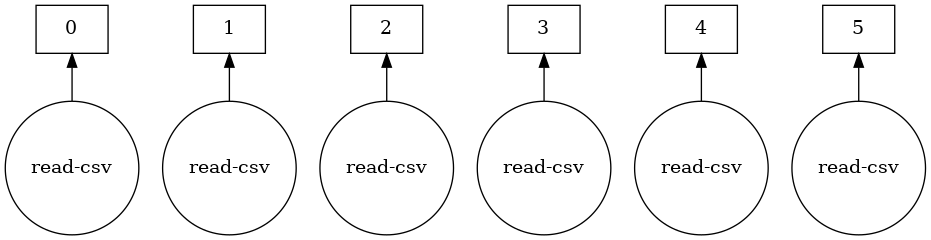

In [21]:
dd_sample_small.visualize()

### When does the task graph get executed?

In [22]:
dd_sample_small.compute()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0        -594.0    -744.0     -42.0    -360.0     367.0      62.0    -486.0   
1          42.0    -372.0    -111.0    -231.0     177.0      63.0    -484.0   
2        -239.0    -372.0     -90.0    -107.0     -41.0     -75.0    -475.0   
3         131.0      12.0    -171.0       0.0    -110.0     -69.0    -467.0   
4        -444.0     215.0    -168.0      62.0     -57.0     -89.0    -462.0   
...         ...       ...       ...       ...       ...       ...       ...   
59996    -555.0   -1147.0     188.0    -501.0     -77.0    -857.0    -124.0   
59997    -603.0   -1047.0     177.0    -574.0     -88.0    -746.0    -115.0   
59998    -639.0    -869.0     152.0    -600.0    -163.0    -884.0     -91.0   
59999    -668.0    -633.0      86.0    -623.0    -139.0   -1095.0     -79.0   
60000    -666.0    -268.0      57.0    -657.0    -159.0   -1076.0     -48.0   

       sensor_8  sensor_9  sensor_10  
0         532.0    -594.0      516.0  
1         315.0    -565.0      434.0  
2         303.0    -525.0      347.0  
3         310.0    -502.0      270.0  
4         251.0    -415.0      204.0  
...         ...       ...        ...  
59996    -844.0    -221.0     -356.0  
59997    -877.0     -77.0     -292.0  
59998    -946.0    -123.0     -168.0  
59999   -1025.0     -17.0       18.0  
60000   -1008.0      60.0      198.0  

[360006 rows x 10 columns]

In [23]:
type(dd_sample_small.compute())

pandas.core.frame.DataFrame

In [24]:
dd_sample_small.compute().shape

(360006, 10)

#### Let's check what is there inside one partition

In [25]:
dd_sample_small.partitions[3]

Dask DataFrame Structure:
              sensor_1 sensor_2 sensor_3 sensor_4 sensor_5 sensor_6 sensor_7 sensor_8 sensor_9 sensor_10
npartitions=1                                                                                           
               float32  float32  float32  float32  float32  float32  float32  float32  float32   float32
                   ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
Dask Name: blocks, 7 tasks

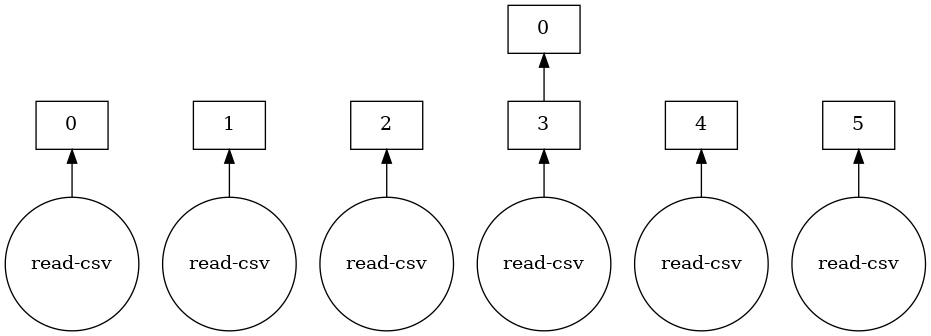

In [26]:
dd_sample_small.partitions[3].visualize()

In [27]:
dd_sample_small.partitions[3].compute()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0         339.0    -134.0     224.0     277.0     194.0     306.0      38.0   
1         403.0       0.0     174.0     232.0     221.0     290.0      27.0   
2         474.0     100.0     108.0     169.0     210.0     302.0      48.0   
3         481.0     148.0      11.0     125.0     190.0     409.0      51.0   
4         499.0     182.0      -5.0      82.0     212.0     467.0      65.0   
...         ...       ...       ...       ...       ...       ...       ...   
59996    -376.0    -328.0      44.0    -273.0      86.0    -607.0     -29.0   
59997    -338.0    -174.0      31.0    -294.0      62.0    -626.0     -35.0   
59998    -318.0     -89.0     129.0    -297.0      31.0    -559.0     -23.0   
59999    -335.0     -43.0     121.0    -305.0      14.0    -616.0     -18.0   
60000    -324.0       2.0     150.0    -306.0     -53.0    -715.0      -1.0   

       sensor_8  sensor_9  sensor_10  
0          48.0    -323.0      246.0  
1        -129.0    -376.0      247.0  
2         -46.0    -414.0      224.0  
3          -5.0    -425.0      189.0  
4         -40.0    -424.0      136.0  
...         ...       ...        ...  
59996    -363.0     373.0     -231.0  
59997    -155.0     383.0     -239.0  
59998    -210.0     373.0     -252.0  
59999    -184.0     363.0     -272.0  
60000    -290.0     347.0     -306.0  

[60001 rows x 10 columns]

In [28]:
type(dd_sample_small.partitions[3].compute())

pandas.core.frame.DataFrame

#### Let's check what is there inside all the partitions

In [29]:
dd_sample_small.map_partitions(type).compute()

0    <class 'pandas.core.frame.DataFrame'>
1    <class 'pandas.core.frame.DataFrame'>
2    <class 'pandas.core.frame.DataFrame'>
3    <class 'pandas.core.frame.DataFrame'>
4    <class 'pandas.core.frame.DataFrame'>
5    <class 'pandas.core.frame.DataFrame'>
dtype: object

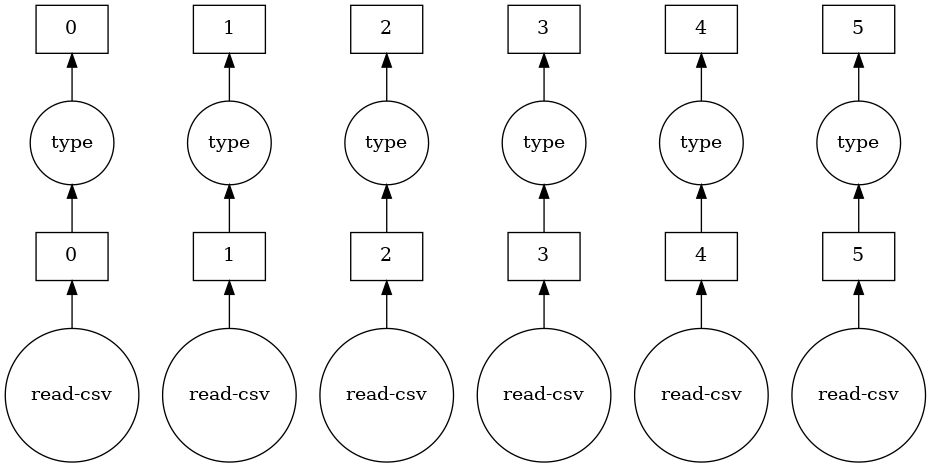

In [30]:
dd_sample_small.map_partitions(type).visualize()

#### We can invoke common Pandas APIs on top of Dask DataFrame

In [31]:
dd_sample_small.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0    -594.0    -744.0     -42.0    -360.0     367.0      62.0    -486.0   
1      42.0    -372.0    -111.0    -231.0     177.0      63.0    -484.0   
2    -239.0    -372.0     -90.0    -107.0     -41.0     -75.0    -475.0   
3     131.0      12.0    -171.0       0.0    -110.0     -69.0    -467.0   
4    -444.0     215.0    -168.0      62.0     -57.0     -89.0    -462.0   

   sensor_8  sensor_9  sensor_10  
0     532.0    -594.0      516.0  
1     315.0    -565.0      434.0  
2     303.0    -525.0      347.0  
3     310.0    -502.0      270.0  
4     251.0    -415.0      204.0

In [32]:
dd_sample_small.tail()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
59996    -555.0   -1147.0     188.0    -501.0     -77.0    -857.0    -124.0   
59997    -603.0   -1047.0     177.0    -574.0     -88.0    -746.0    -115.0   
59998    -639.0    -869.0     152.0    -600.0    -163.0    -884.0     -91.0   
59999    -668.0    -633.0      86.0    -623.0    -139.0   -1095.0     -79.0   
60000    -666.0    -268.0      57.0    -657.0    -159.0   -1076.0     -48.0   

       sensor_8  sensor_9  sensor_10  
59996    -844.0    -221.0     -356.0  
59997    -877.0     -77.0     -292.0  
59998    -946.0    -123.0     -168.0  
59999   -1025.0     -17.0       18.0  
60000   -1008.0      60.0      198.0

In [33]:
dd_sample_small.describe()

Dask DataFrame Structure:
              sensor_1 sensor_2 sensor_3 sensor_4 sensor_5 sensor_6 sensor_7 sensor_8 sensor_9 sensor_10
npartitions=1                                                                                           
               float64  float64  float64  float64  float64  float64  float64  float64  float64   float64
                   ...      ...      ...      ...      ...      ...      ...      ...      ...       ...
Dask Name: describe-numeric, 250 tasks

In [34]:
dd_sample_small.describe().visualize()

In [35]:
dd_sample_small.describe().compute()

sensor_1       sensor_2       sensor_3       sensor_4  \
count  360006.000000  360006.000000  360006.000000  360006.000000   
mean        0.454548       0.798759      -7.053049      -1.260923   
std       375.075378     851.624695     355.042816     331.925171   
min     -5690.000000   -9415.000000   -2115.000000   -2506.000000   
25%       -94.000000    -254.000000     -90.000000     -96.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%       304.000000    1025.000000     303.000000     368.000000   
max      5194.000000   11189.000000    1919.000000    2758.000000   

            sensor_5       sensor_6       sensor_7       sensor_8  \
count  300005.000000  360006.000000  360006.000000  360006.000000   
mean       -0.245256       0.662408       0.617990       0.703758   
std       194.703629     467.789856     315.291504     366.441345   
min     -2546.000000   -3064.000000   -3153.000000   -2584.000000   
25%       -56.000000    -148.000000    -109.000000    -109.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%       154.000000     560.000000     288.000000     334.000000   
max      2982.000000    2350.000000    3378.000000    2043.000000   

            sensor_9      sensor_10  
count  358512.000000  360006.000000  
mean        0.273307      -1.161120  
std       337.102570     682.615845  
min     -2550.000000   -4977.000000  
25%      -107.000000    -205.000000  
50%         0.000000       0.000000  
75%       364.000000     597.000000  
max      2127.000000    5328.000000

#### Let's compute the maximum value of the `sensor_1` feature

In [36]:
dd_sample_small.sensor_1.max()

dd.Scalar<series-..., dtype=float32>

Dask has not actually **executed** the code yet. It's lazy. Computation is done only when explicitly asked.

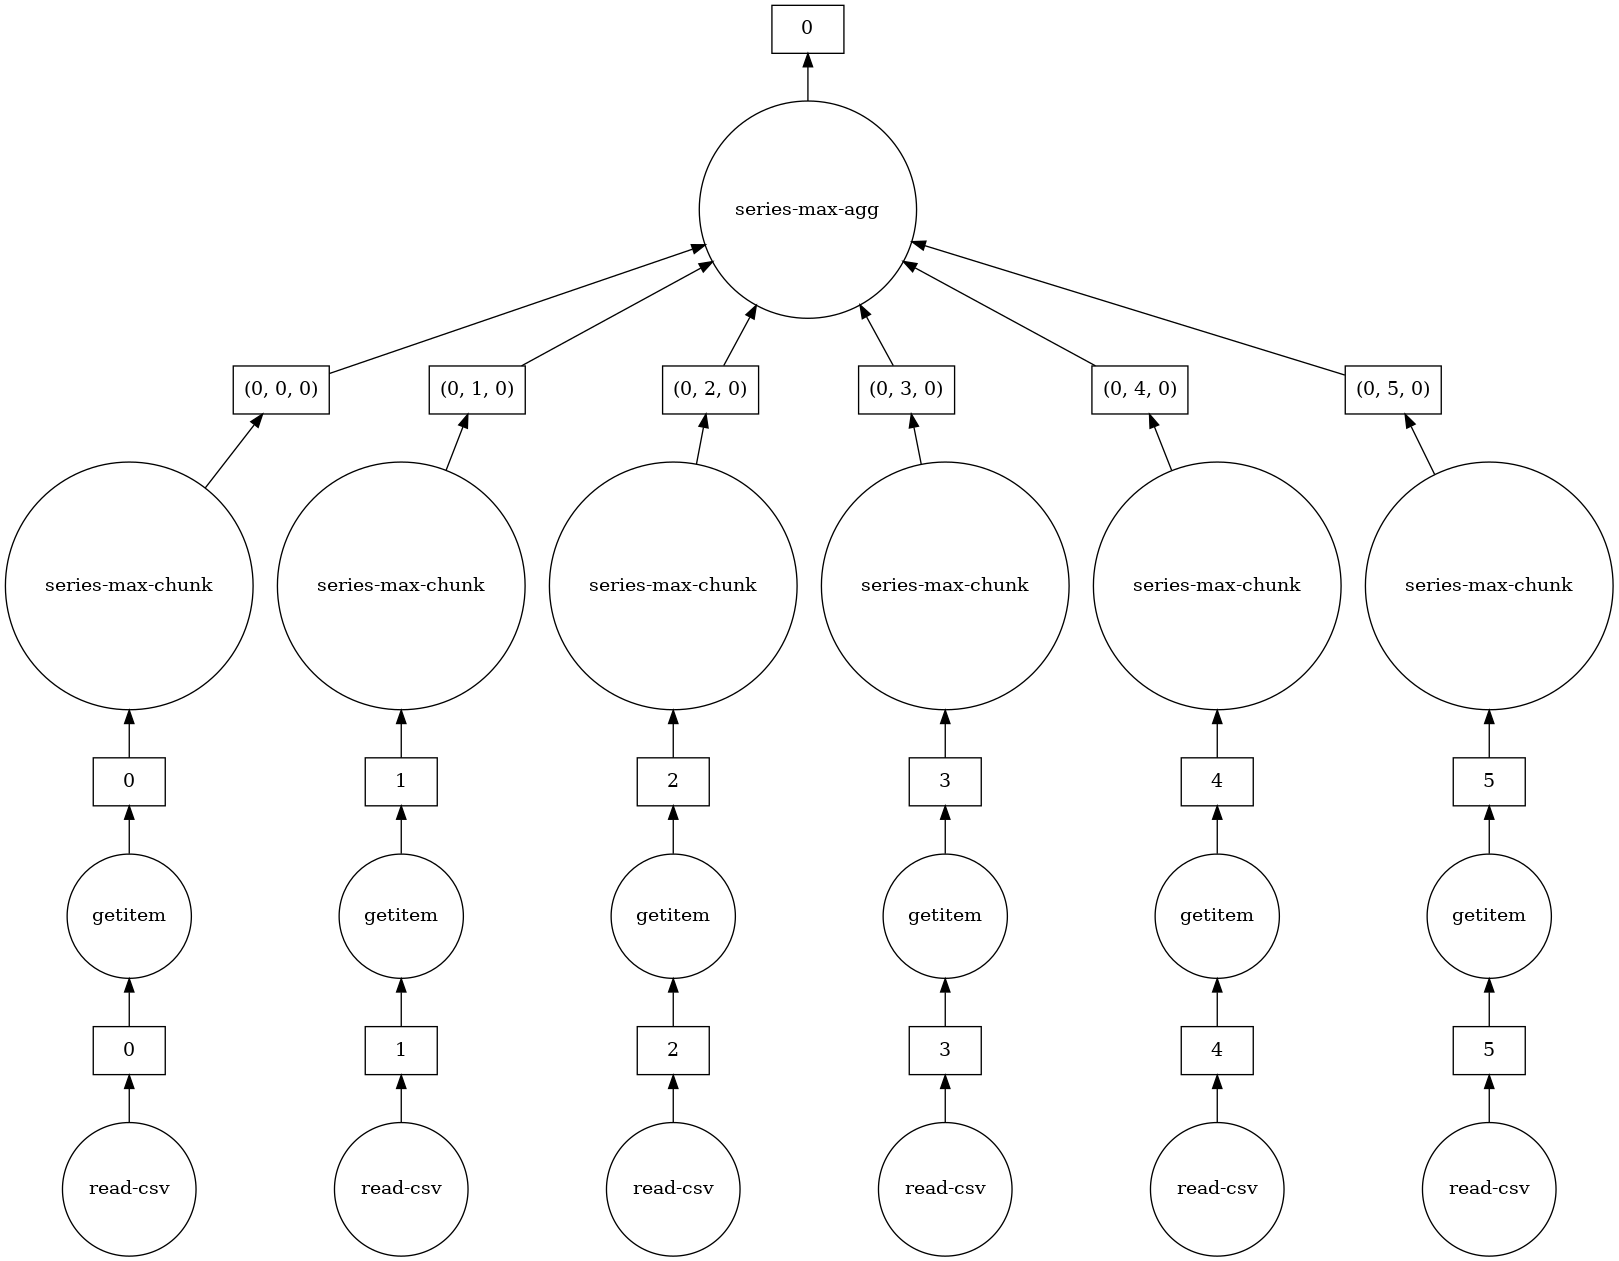

In [37]:
dd_sample_small.sensor_1.max().visualize()

In [38]:
dd_sample_small.sensor_1.max().compute()

5194.0

#### What just happened?
- Dask checked the input path. Identified the matching files
- A bunch of jobs were created. Here, one job per chunk/partition. 
- Each CSV file is read from the memory and loaded into a Pandas Dataframe
- For each Pandas DataFrame, maximum value of `sensor_1` feature is computed
- Results from multiple Pandas DataFrame are combined to get the final result, i.e., the maximum value of `sensor_1` across all the CSVs
- Look at the Dask Dashboard before and after the compute()


#### Notes on `compute()`:
- The result of `compute()` must fit in-memory.


#### Repeat it for a larger Data

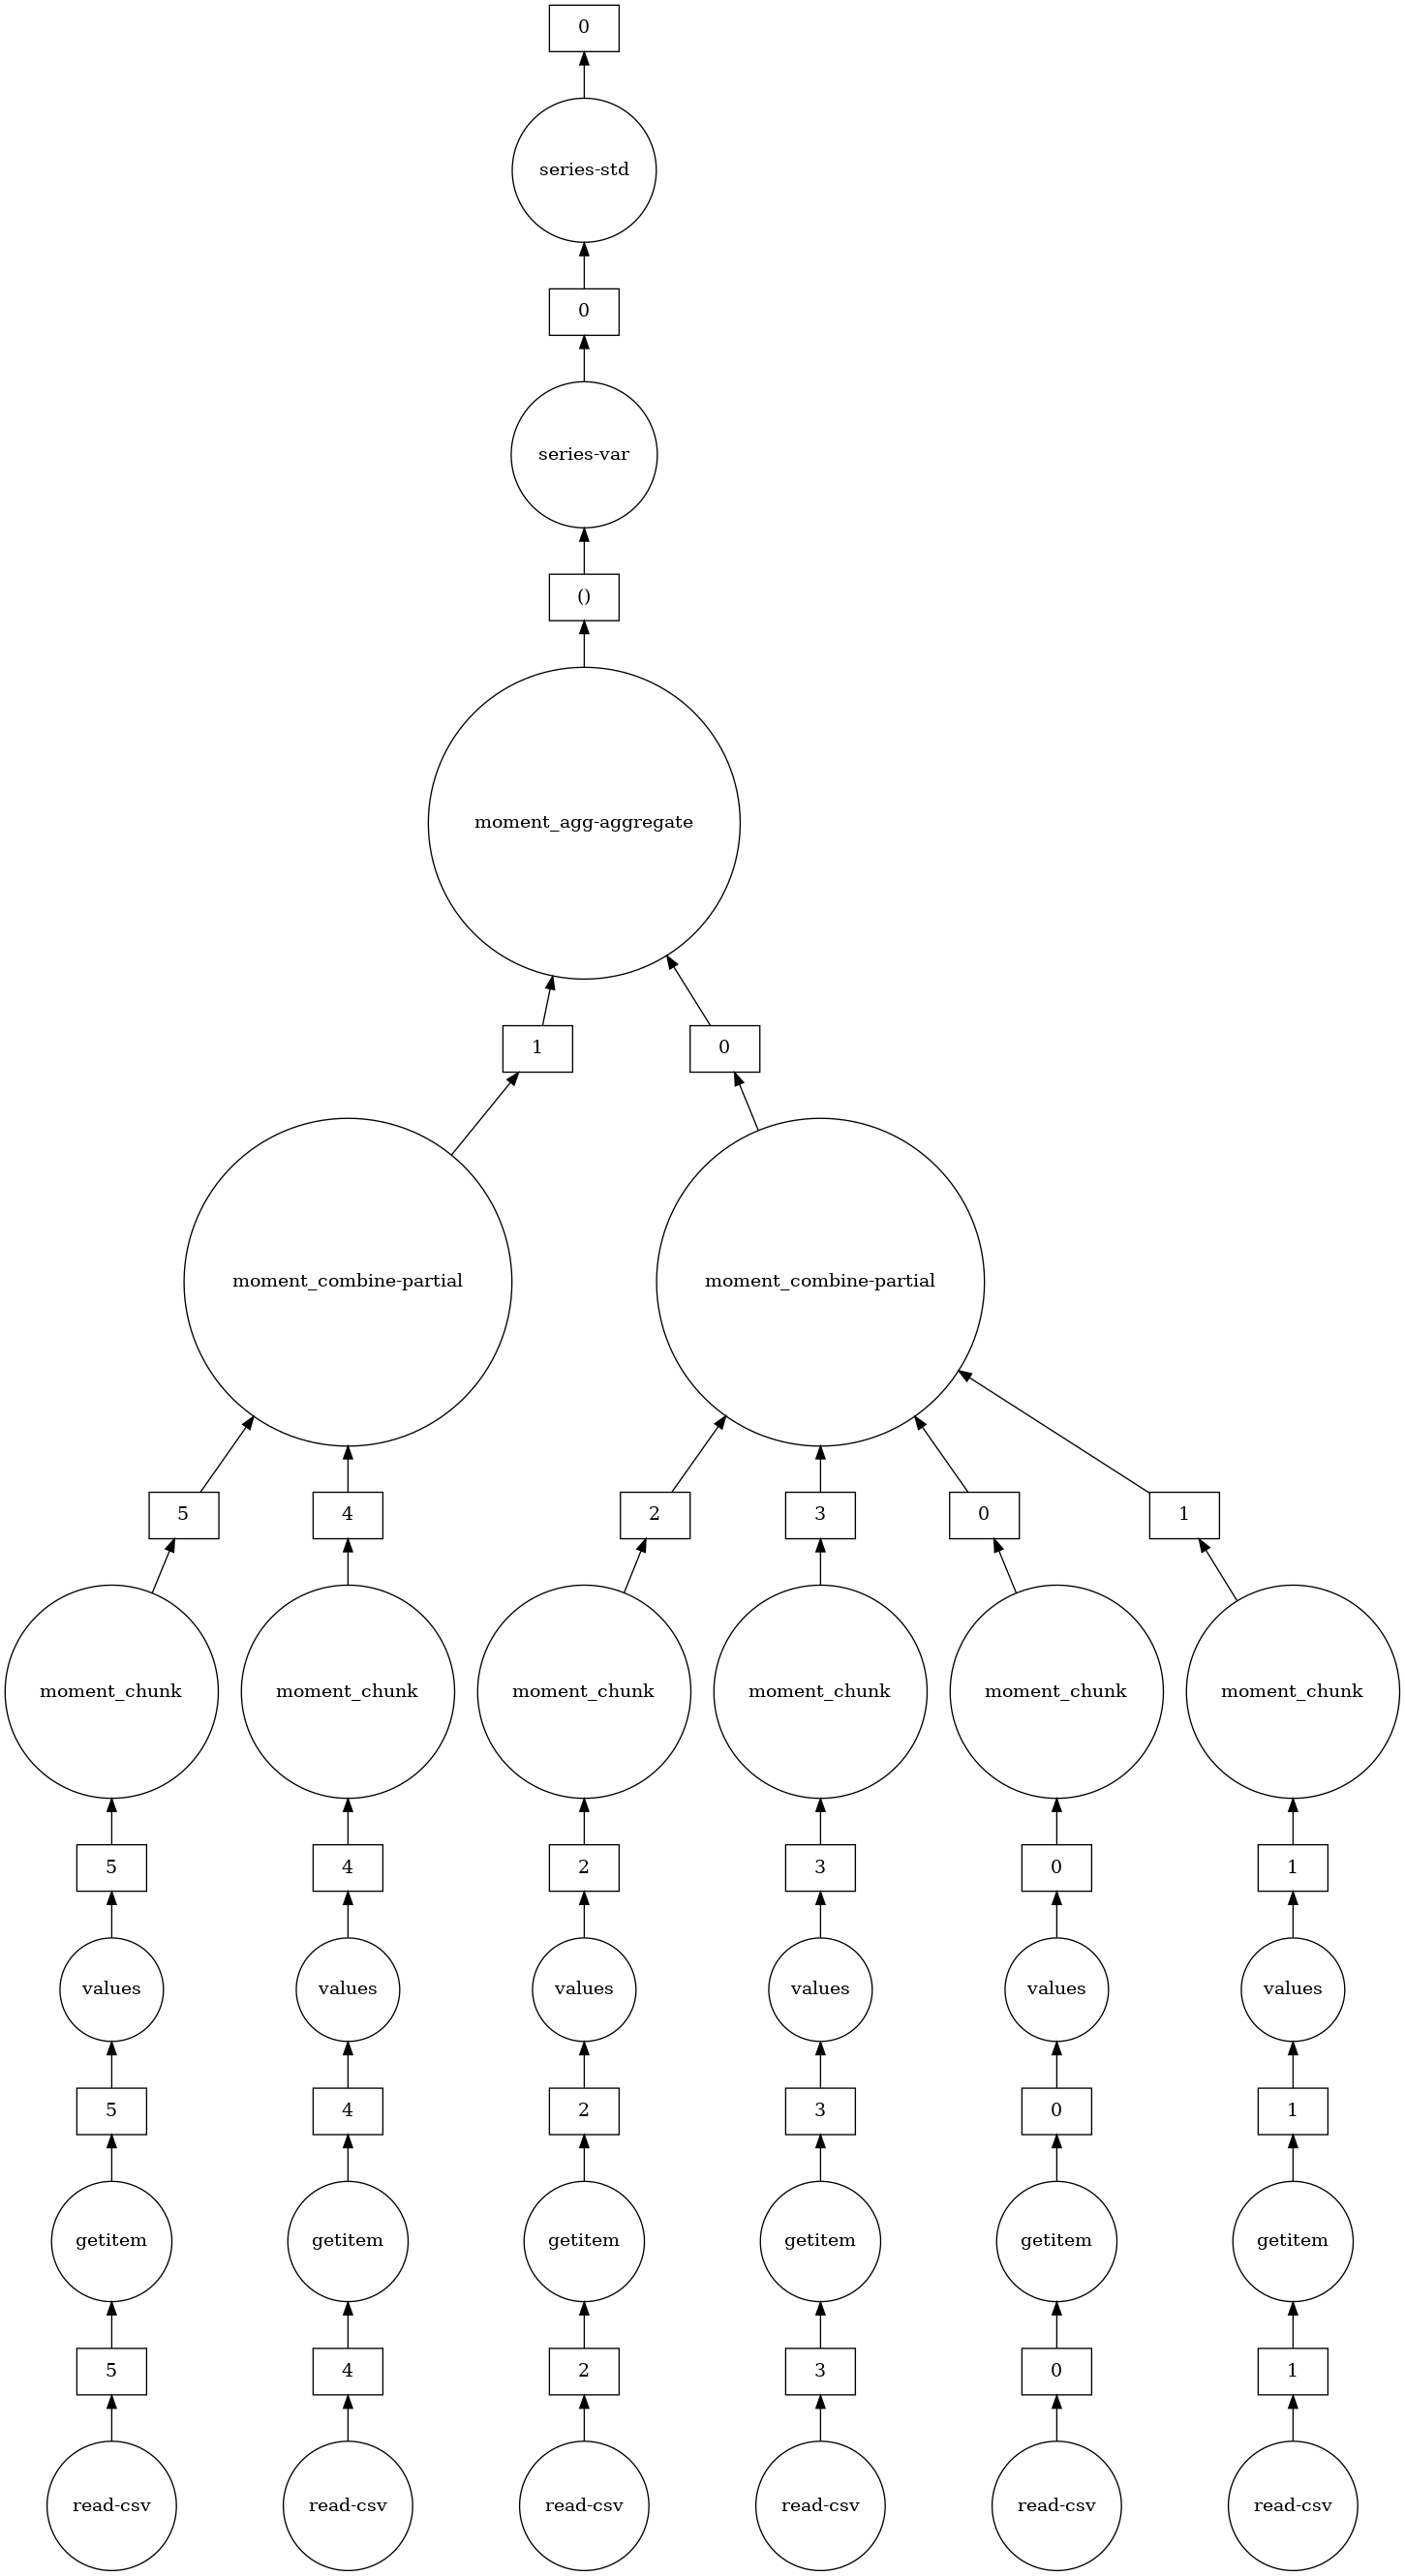

In [39]:
dd_sample_small.sensor_1.std().visualize()

In [40]:
%%time
dd_seg.sensor_1.std().compute()

CPU times: user 30.2 s, sys: 4.69 s, total: 34.8 s
Wall time: 1min 9s


1655.2306

#### Sharing computation for multiple operations

Dask allows duplicate computations to be shared, and only computed once.

In [41]:
%%time
dd_sample_small.sensor_1.std().compute()
dd_sample_small.sensor_1.mean().compute()

CPU times: user 351 ms, sys: 32.1 ms, total: 383 ms
Wall time: 579 ms


0.45454797975589295

In [42]:
%%time
sensor_one_std = dd_sample_small.sensor_1.std()
sensor_one_max = dd_sample_small.sensor_1.max()
sensor_one_mean = dd_sample_small.sensor_1.mean()

dd.compute(sensor_one_std, sensor_one_mean)

CPU times: user 78.3 ms, sys: 17.2 ms, total: 95.5 ms
Wall time: 191 ms


(375.07538, 0.45454797975589295)

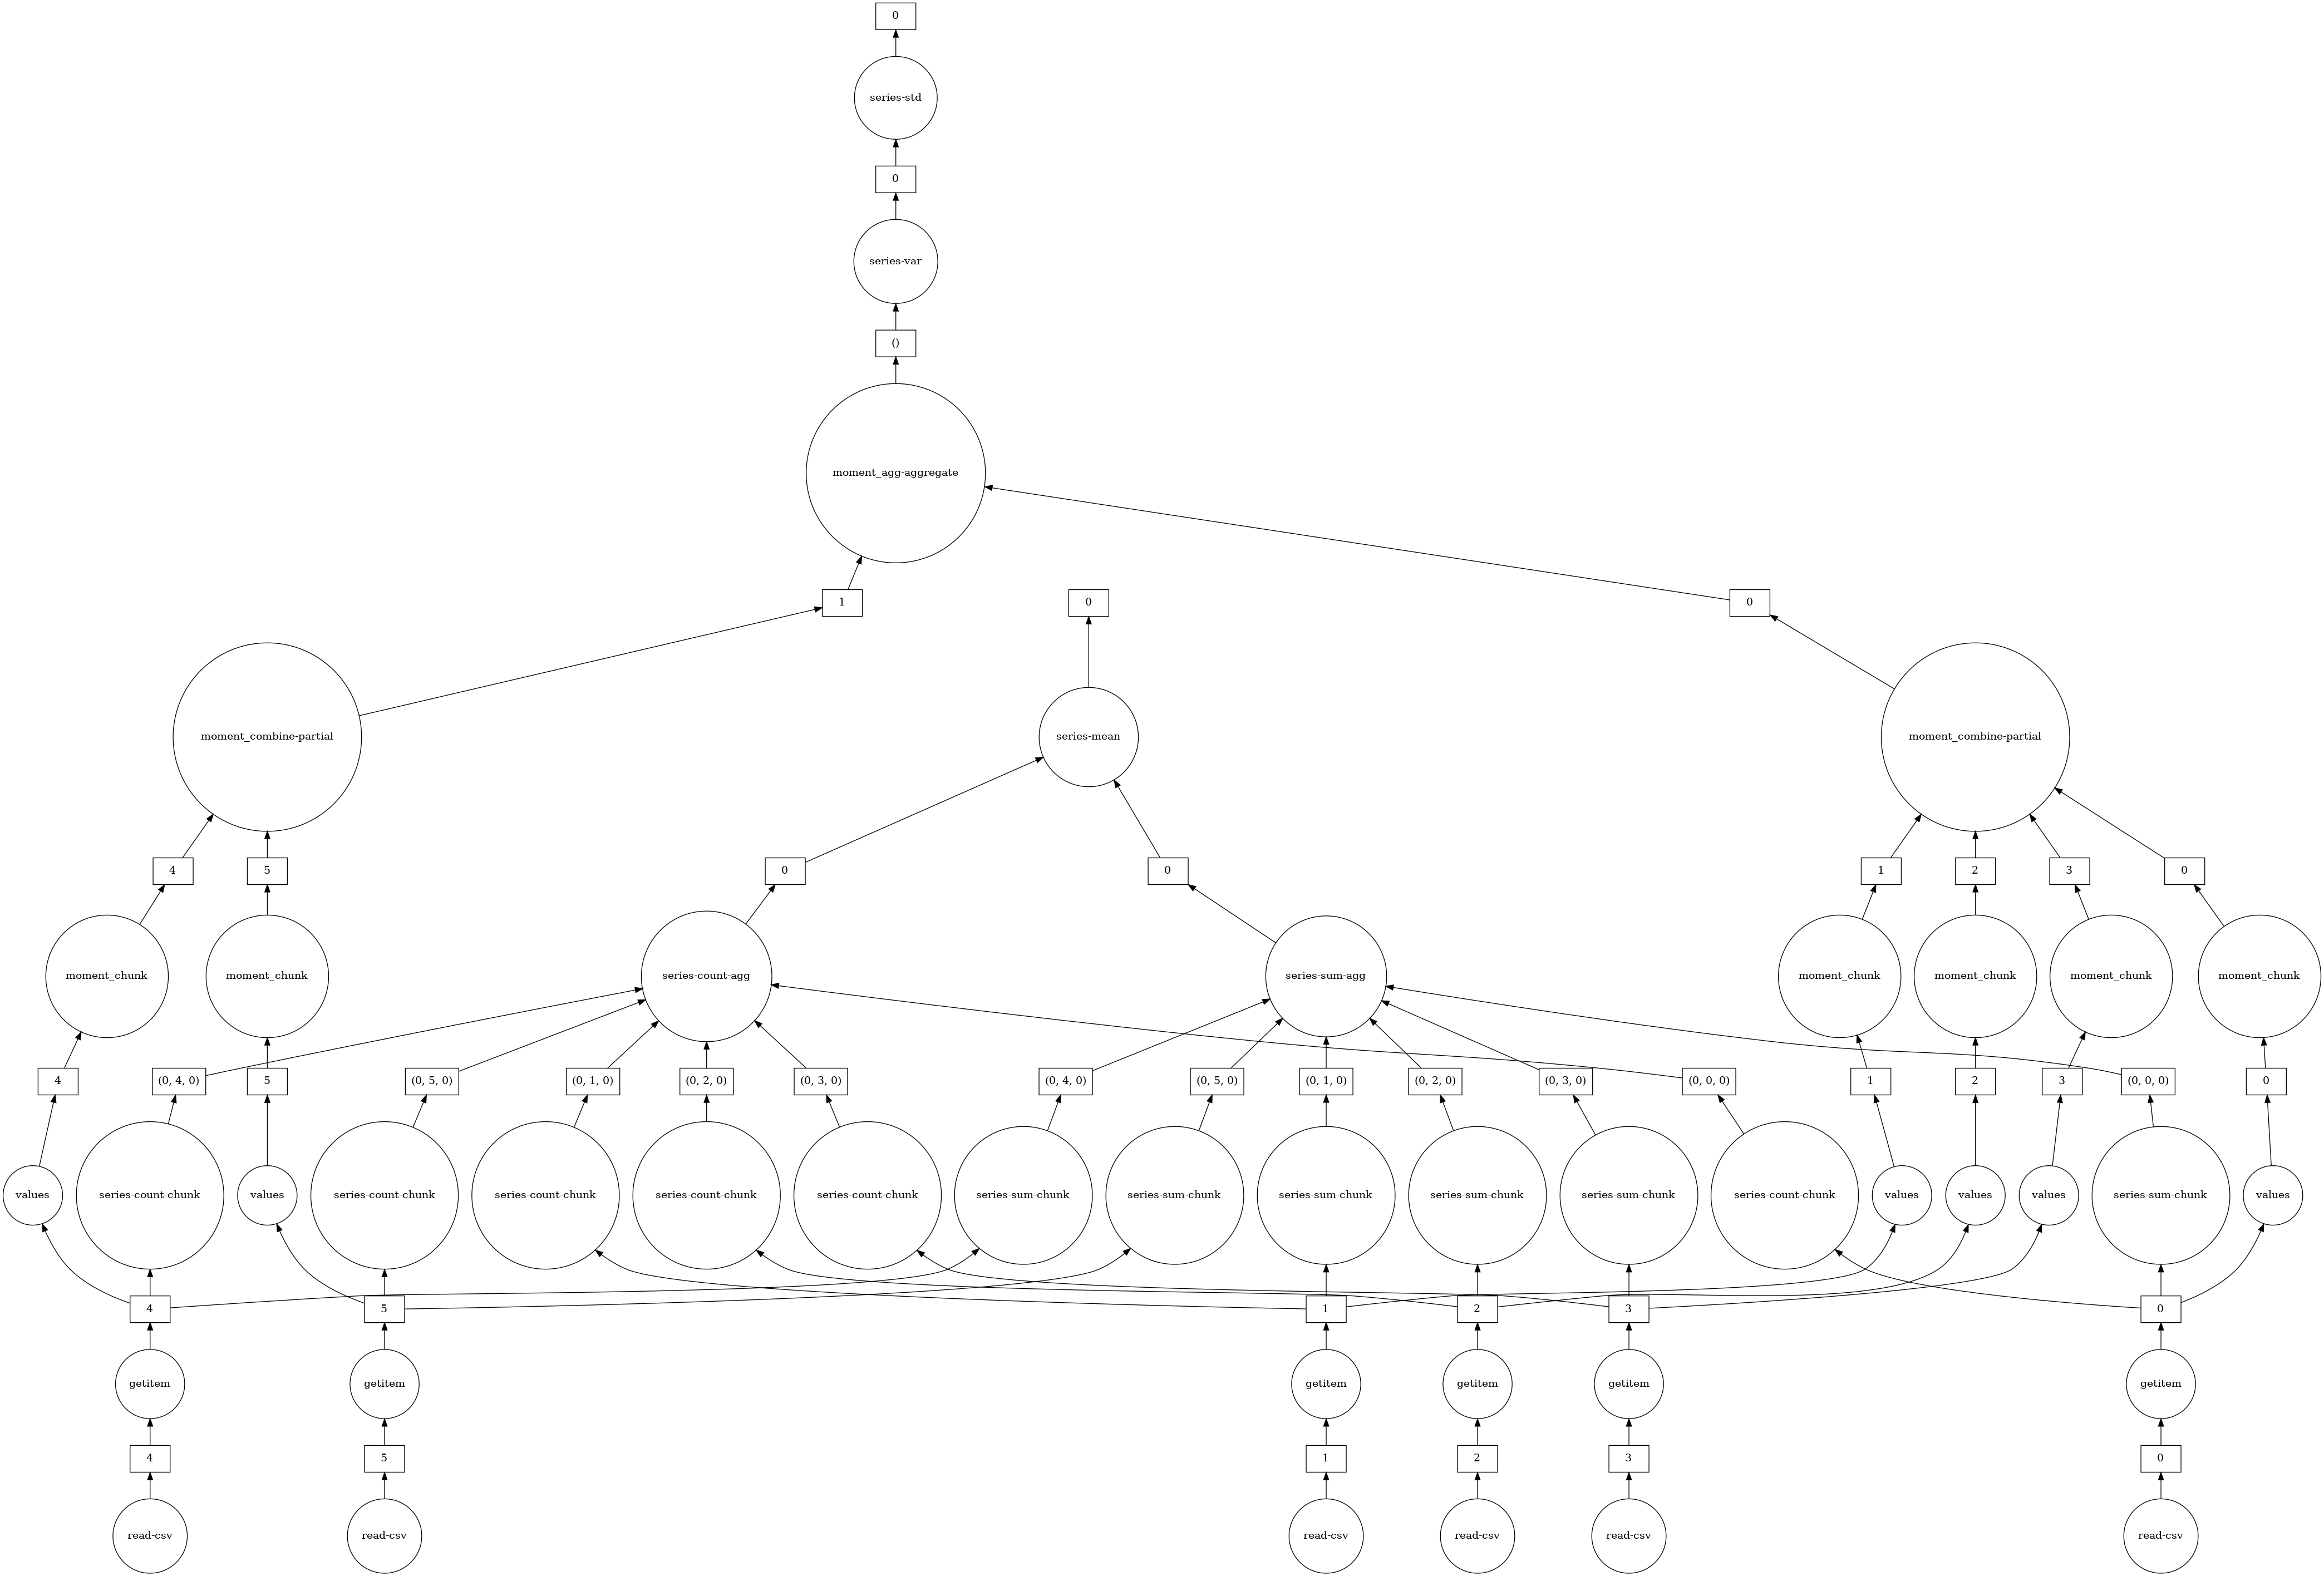

In [43]:
dask.visualize(sensor_one_std, sensor_one_mean)

In [44]:
dask.compute(sensor_one_std, sensor_one_mean, sensor_one_max)

(375.07538, 0.45454797975589295, 5194.0)

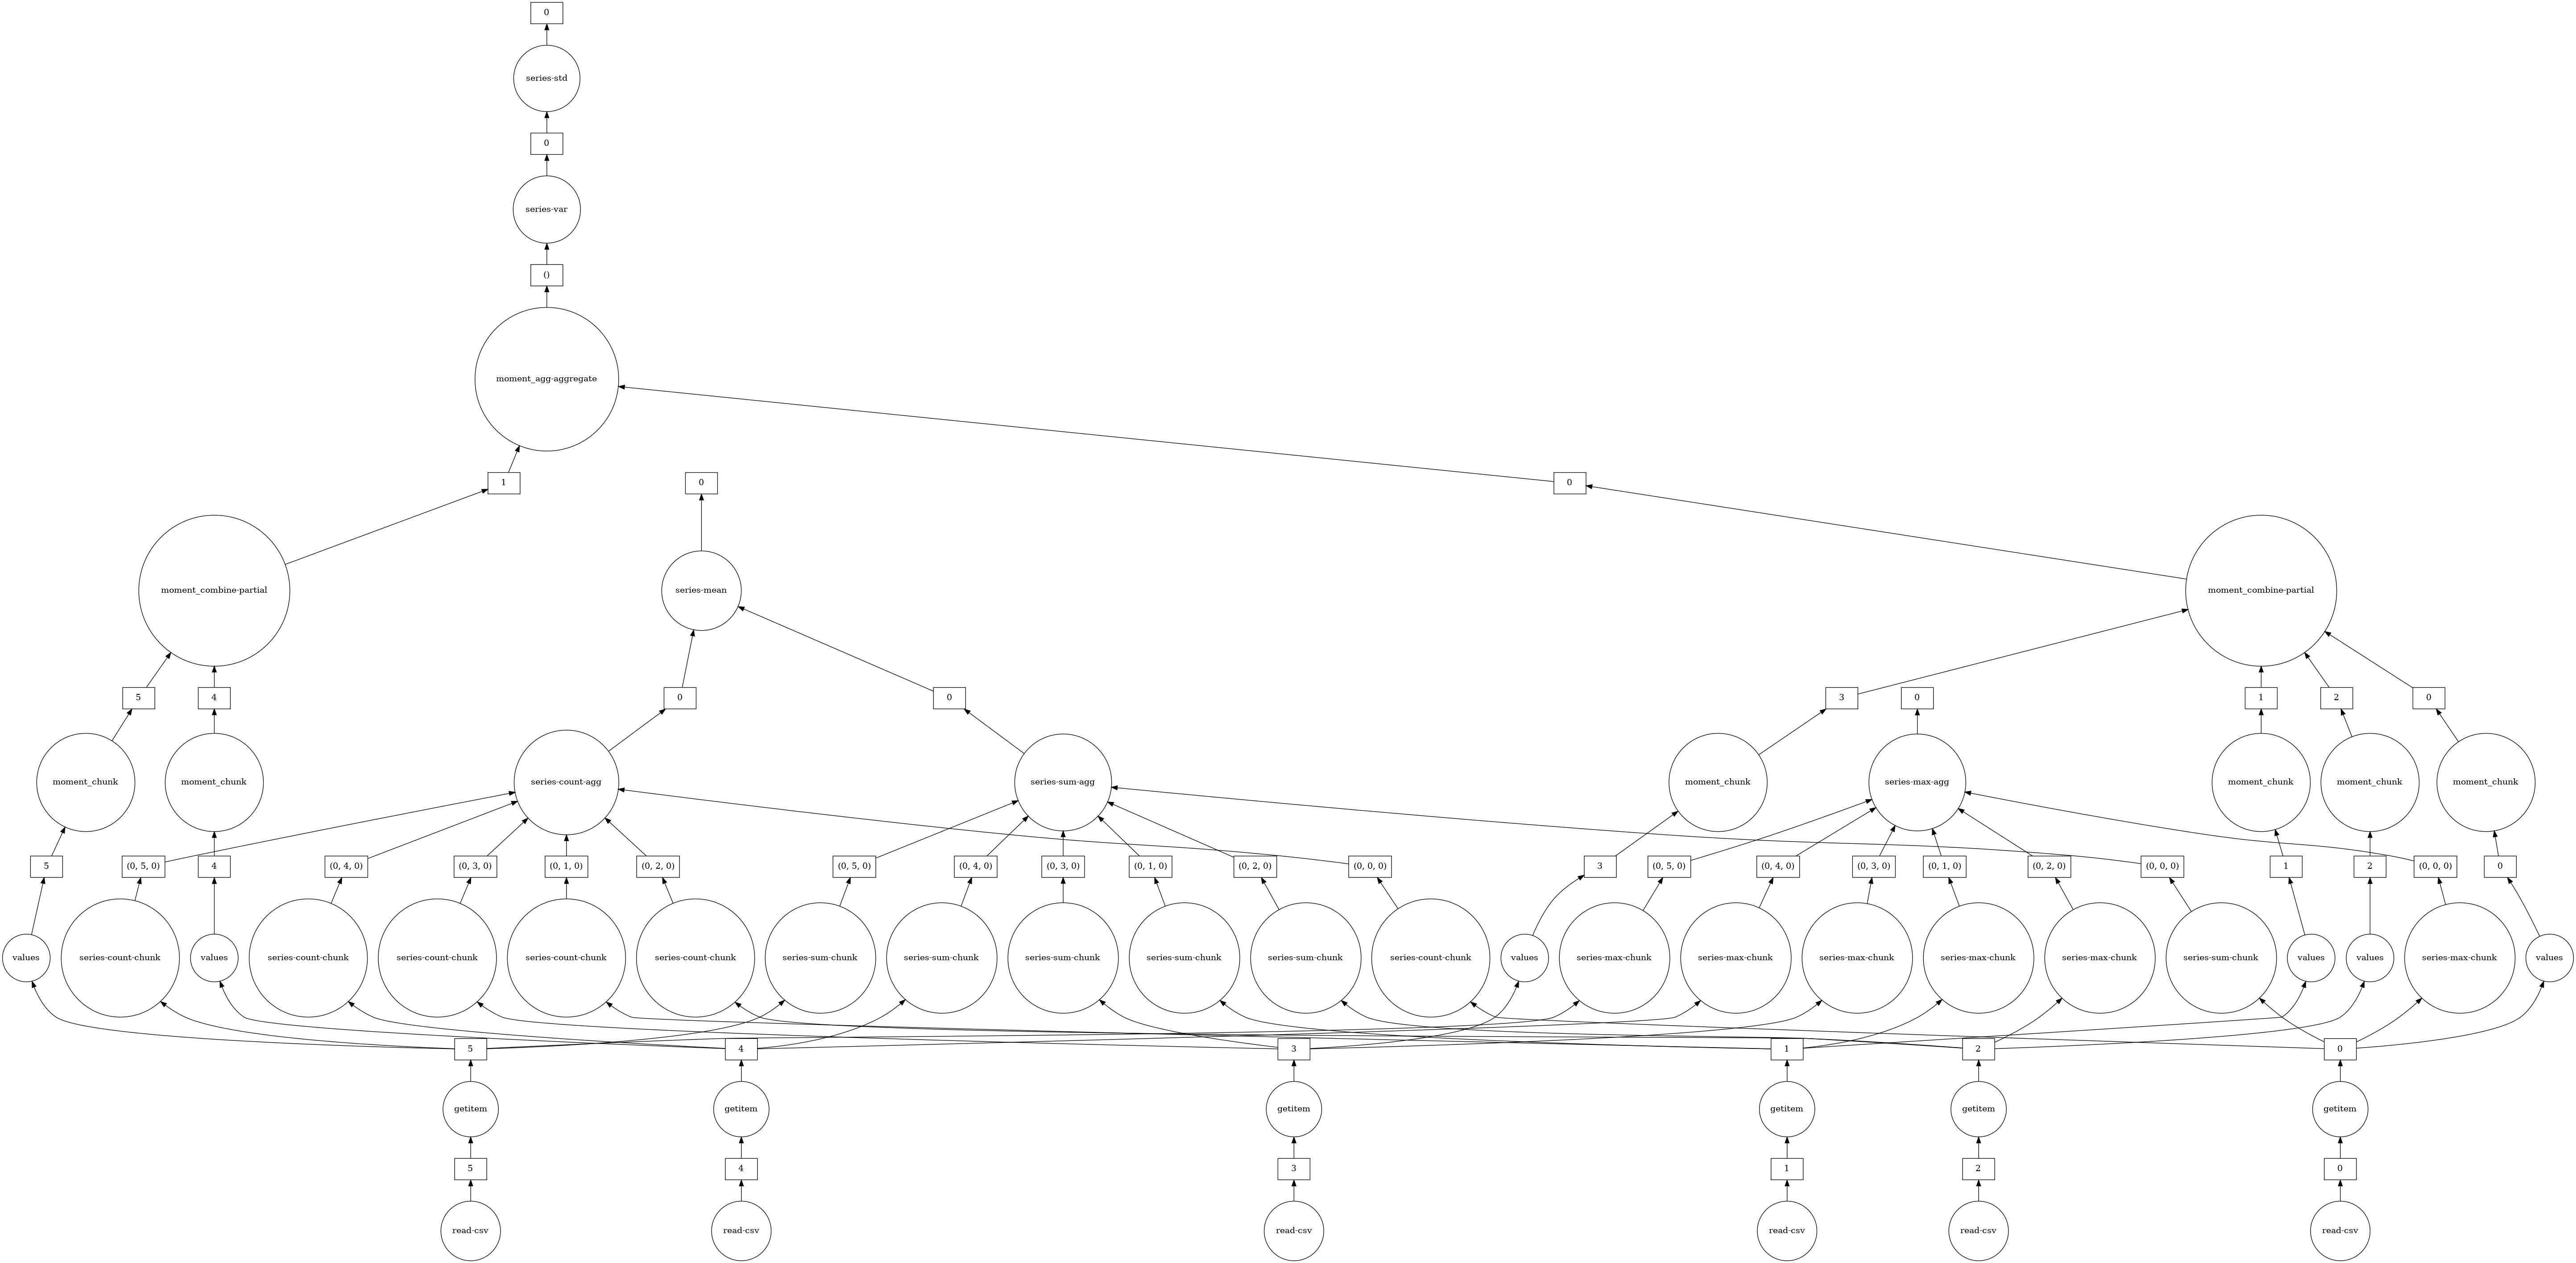

In [45]:
dask.visualize(sensor_one_std, sensor_one_mean, sensor_one_max)

#### Notes about `dask.compute()`
- When calling dask.compute, task graphs for multiple results are merged
- Shared operations are computed only once. 
- `dask.compute()` does the following once:
    - Reading the data for individual partitions (`read_csv` in this case)
    - some of the necessary reductions (sum, count etc.)
    - Common steps if any

### How to execute custom functionality

#### Problem Statement

- I have a function which works well on one Pandas DataFrame. How can I parallelize it over multiple Pandas DataFrame?

- `map_partitions()` is the answer. It applies the function in an **embarrassingly parallel** way to multiple Pandas DataFrame 

#### Problem 1

I want to find out the `skewness` of `sensor_1` for different segments. `skewness` is not implemented in `Dask`, however, it's implemented in `Pandas`

In [46]:
dd_sample_small.sensor_1.map_partitions(pd.DataFrame.skew).compute()

0   -0.031951
1   -0.024434
2   -0.049013
3   -0.046156
4    0.037749
5    0.102469
dtype: float64

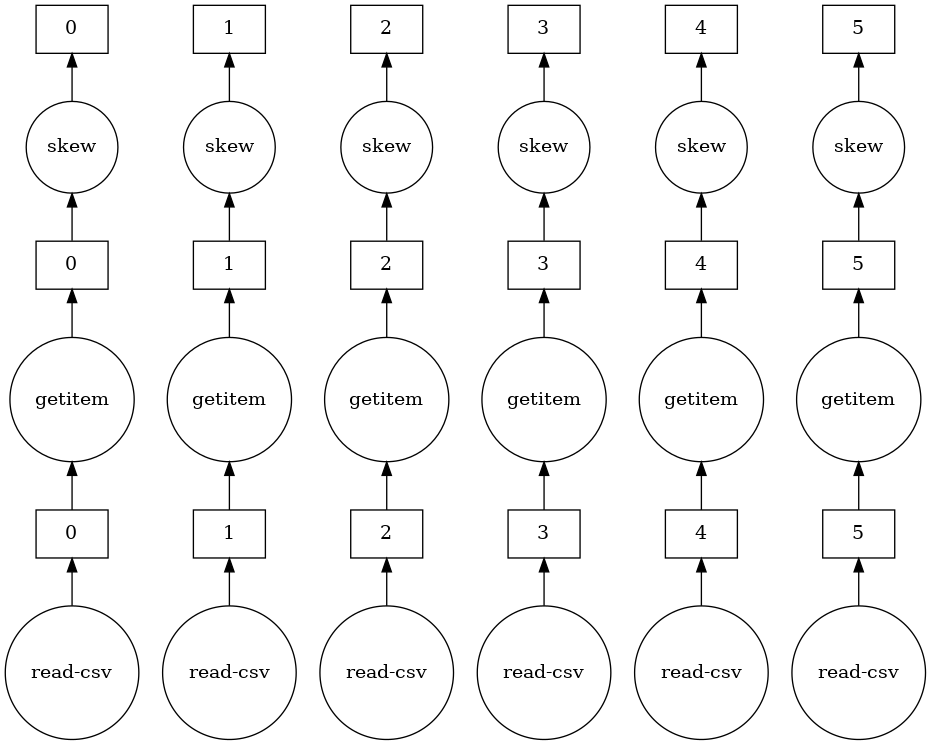

In [47]:
dd_sample_small.sensor_1.map_partitions(pd.DataFrame.skew).visualize()

#### Problem 2

Calculate the percentage of missing values across sensors for all the segments

In [48]:
def get_missing_sensors(df):
    """
    Returns a DataFrame consisting percentage of missing data per sensor
    """
    df_missing_percentage = df.isna().mean().to_frame().transpose()
    df_missing_percentage = df_missing_percentage.astype(np.float16)
    return df_missing_percentage

In [49]:
df_train_seg_missing = dd_sample_small.map_partitions(get_missing_sensors).compute()

df_train_seg_missing

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
0       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   sensor_8  sensor_9  sensor_10  
0       0.0  0.000000        0.0  
0       0.0  0.024902        0.0  
0       0.0  0.000000        0.0  
0       0.0  0.000000        0.0  
0       0.0  0.000000        0.0  
0       0.0  0.000000        0.0

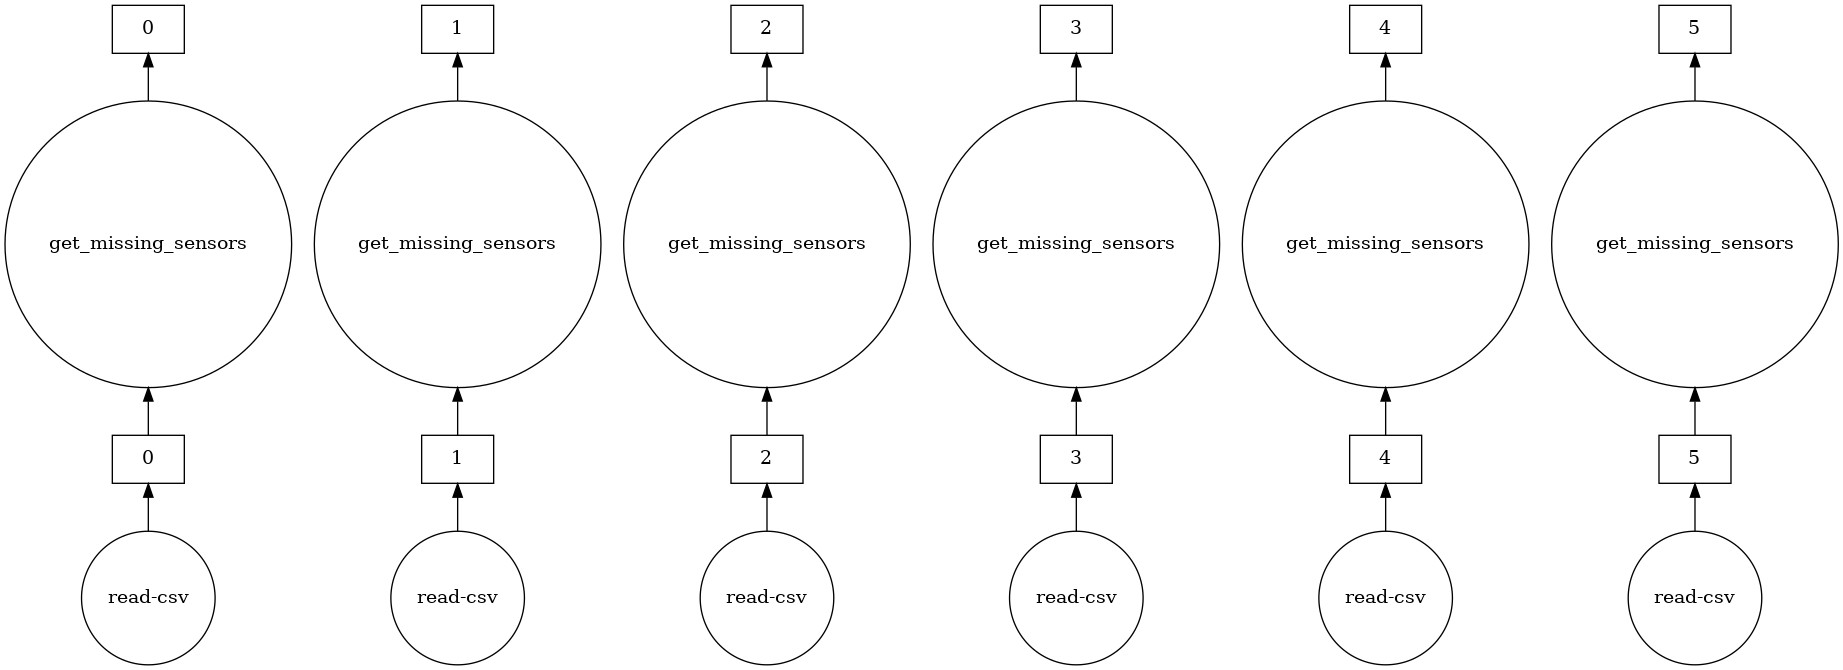

In [50]:
dd_sample_small.map_partitions(get_missing_sensors).visualize()

#### Note
 - `map_partitions()` applies any Python function on each DataFrame partition.

### Let's do larger than memory computation

- Load 30 GB of data from the 8951 CSV files which are located under `train` and `test` directory together resulting in a Dask DataFrame with 8951 partitions.
- If all these CSV files are loaded in the main memory together, it should occupy ~ **42 GB**. Size of the RAM in this machine is 28GB.
- Find the std() of sensor_1 across the these 8951 partitions

In [51]:
TRAIN_DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/train/"
TEST_DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/test/"

In [52]:
%%time
dd_large = dd.read_csv(
    urlpath=[f"{TRAIN_DATA_DIR}/*.csv", f"{TEST_DATA_DIR}/*.csv"], 
    blocksize=None)

CPU times: user 1.76 s, sys: 269 ms, total: 2.03 s
Wall time: 2.41 s


In [ ]:
# Code to compute the memory that would be occupied by the Pandas DF across 8951 partitions.

memory_usage = dd_large.memory_usage(deep=True).compute()
memory_usage.sum()/(10**9)

In [ ]:
dd_large.sensor_1.max().compute()

### Close the client

In [ ]:
client.close()